Saving cat.jpg to cat (4).jpg


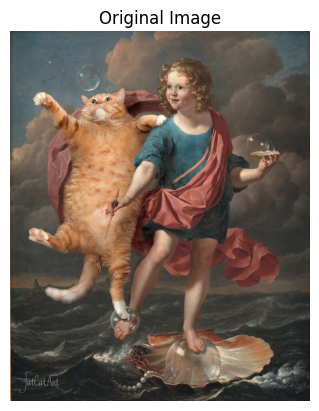

In [26]:
# Import library yang dibutuhkan
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from google.colab import files
from google.colab.patches import cv2_imshow  # Fungsi khusus untuk Google Colab

# Fungsi untuk menampilkan gambar dalam format RGB
def show_image(title, img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Upload file gambar yang akan digunakan
uploaded = files.upload()
filename = list(uploaded.keys())[0]
image = cv2.imread(filename)
show_image("Original Image", image)

#1. Ekstraksi Garis dengan Hough Transform#

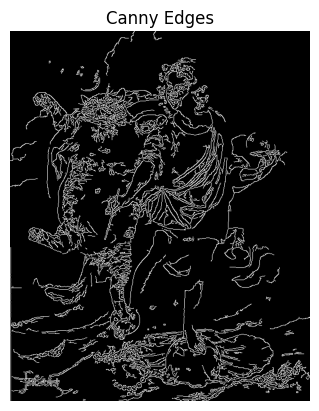

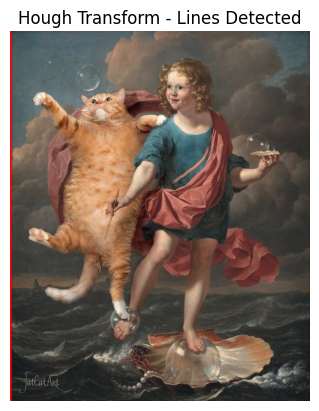

In [18]:
# Konversi gambar ke grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Deteksi tepi dengan Canny Edge Detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
show_image("Canny Edges", edges)

# Deteksi garis dengan Hough Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# Gambar garis pada gambar asli
line_img = image.copy()
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

show_image("Hough Transform - Lines Detected", line_img)


Metode Hough Transform digunakan untuk mendeteksi garis berdasarkan hasil edge detection dari Canny. Garis-garis yang terdeteksi ditampilkan dalam warna merah pada gambar. Hough Transform bekerja dengan mengubah koordinat garis dari ruang kartesius ke ruang parameter polar (rho, theta). Garis yang terdeteksi bisa saja termasuk noise jika threshold parameter tidak optimal. Jika garis terlihat berlebihan, pengaturan threshold pada Canny atau Hough Transform perlu diperbaiki.

#2. Template Matching untuk Deteksi Objek#

Unggah gambar utama (tempat objek dicari):


Saving cat.jpg to cat (6).jpg
Unggah gambar template (objek yang dicari):


Saving cat_template.jpg to cat_template (5).jpg


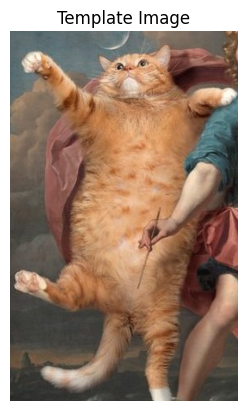

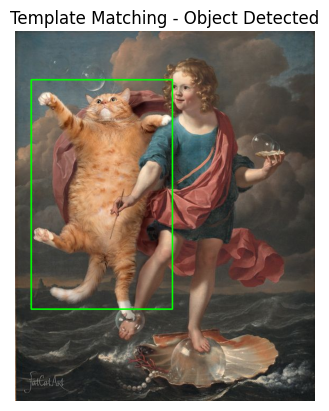

In [30]:
# Upload gambar utama
print("Unggah gambar utama (tempat objek dicari):")
uploaded = files.upload()
filename_main = list(uploaded.keys())[0]
image = cv2.imread(filename_main)

# Upload gambar template
print("Unggah gambar template (objek yang dicari):")
uploaded_template = files.upload()
filename_template = list(uploaded_template.keys())[0]
template = cv2.imread(filename_template)

# Konversi gambar ke grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# Dapatkan ukuran template
h, w = template.shape[:-1]  # Baris dan kolom gambar template

# Template Matching menggunakan metode TM_CCOEFF_NORMED
result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
_, _, _, max_loc = cv2.minMaxLoc(result)

# Gambar kotak pada lokasi deteksi
matched_img = image.copy()
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(matched_img, top_left, bottom_right, (0, 255, 0), 2)

# Tampilkan gambar hasil
show_image("Template Image", template)  # Template (objek yang dicari)
show_image("Template Matching - Object Detected", matched_img)  # Hasil deteksi


Template Matching bekerja dengan mencocokkan template pada setiap lokasi dalam gambar utama dan menghitung skor kesesuaian. Titik dengan nilai maksimum menunjukkan lokasi terbaik untuk template. Metode ini sensitif terhadap perubahan skala atau rotasi, sehingga hanya efektif jika template memiliki ukuran dan orientasi yang sama dengan objek target.

#3. Pembuatan Pyramid Gambar#

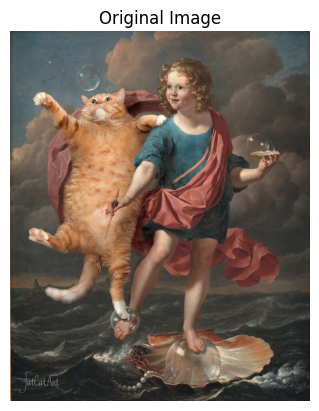

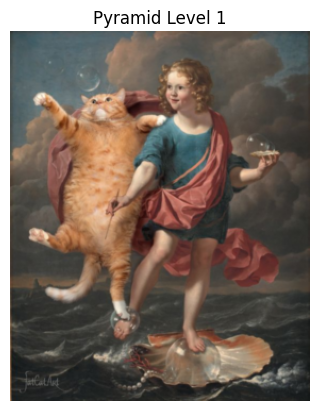

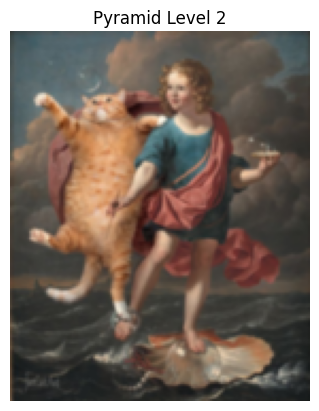

In [22]:
# Membuat gambar pyramid
lower_reso1 = cv2.pyrDown(image)  # Reduksi ukuran pertama
lower_reso2 = cv2.pyrDown(lower_reso1)  # Reduksi ukuran kedua

# Menampilkan gambar pyramid
show_image("Original Image", image)
show_image("Pyramid Level 1", lower_reso1)
show_image("Pyramid Level 2", lower_reso2)


Pyramid Gambar adalah teknik untuk mengubah ukuran gambar secara bertahap ke skala yang lebih kecil atau lebih besar, sehingga terbentuk hirarki gambar dengan berbagai resolusi. Teknik ini umum digunakan dalam Image Processing, terutama untuk aplikasi seperti deteksi objek, segmentasi gambar, dan pengenalan pola.



#4. Deteksi Lingkaran dengan Hough Transform#

Saving circle.jpg to circle (4).jpg


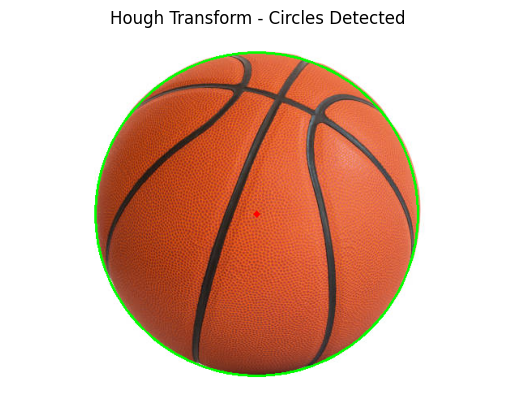

In [23]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
image = cv2.imread(filename)

# Konversi ke grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# GaussianBlur untuk mengurangi noise
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Deteksi lingkaran menggunakan Hough Transform
circles = cv2.HoughCircles(blurred,
                           cv2.HOUGH_GRADIENT,
                           dp=1.2,
                           minDist=100,  # Jarak antar lingkaran diperbesar
                           param1=50,
                           param2=70,  # Tingkatkan threshold akumulasi
                           minRadius=100,  # Radius minimum
                           maxRadius=200)  # Radius maksimum

# Gambar lingkaran yang terdeteksi
circle_img = image.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(circle_img, center, radius, (0, 255, 0), 2)  # Lingkaran
        cv2.circle(circle_img, center, 2, (0, 0, 255), 3)  # Pusat lingkaran


show_image("Hough Transform - Circles Detected", circle_img)


Hough Circle Transform digunakan untuk mendeteksi lingkaran berdasarkan gradien tepi gambar. Algoritma bekerja dengan mencari pola melingkar dalam ruang parameter radius dan pusat lingkaran. Jika deteksi membaca lebih dari satu lingkaran meskipun hanya ada satu lingkaran di gambar, hal ini bisa disebabkan oleh noise atau parameter threshold yang tidak optimal (param1 dan param2). Untuk memperbaikinya, param2 (threshold akumulasi) dapat dinaikkan agar hanya lingkaran dengan kepercayaan tinggi yang terdeteksi.

#5. Ekstraksi Warna Dominan pada Gambar#

Dominant Colors (BGR): [[ 49  53  60]
 [119 149 192]
 [ 85  94 107]]


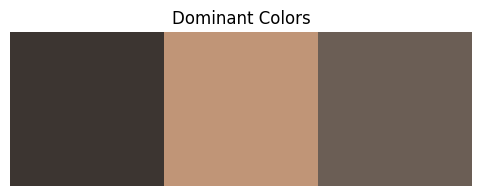

In [27]:
# Konversi gambar menjadi array 2D
pixels = image.reshape(-1, 3)

# K-Means Clustering untuk 3 warna dominan
kmeans = KMeans(n_clusters=3)
kmeans.fit(pixels)

# Menampilkan warna dominan
colors = kmeans.cluster_centers_.astype(int)
print("Dominant Colors (BGR):", colors)

# Visualisasi warna dominan
plt.figure(figsize=(8, 2))
plt.imshow([colors[:, ::-1]])  # Konversi BGR ke RGB
plt.title("Dominant Colors")
plt.axis("off")
plt.show()


 Algoritma K-Means digunakan untuk mengelompokkan piksel gambar menjadi beberapa kluster berdasarkan nilai warnanya. Warna dominan yang dihasilkan mewakili warna paling signifikan dalam gambar. Ini berguna untuk analisis visual atau pengurangan kompleksitas warna.

#6. Deteksi Kontur pada Gambar#

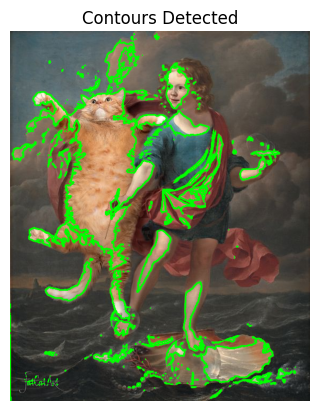

In [28]:
# Konversi gambar ke grayscale dan threshold
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Deteksi kontur
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = image.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

show_image("Contours Detected", contour_img)


Deteksi kontur dilakukan pada gambar biner hasil thresholding. Kontur menggambarkan batas-batas objek dalam gambar. Kontur ini berguna untuk memahami bentuk dan struktur objek, serta untuk keperluan segmentasi.